In [2]:
using DiffEqOperators
using PyPlot
using SparseArrays

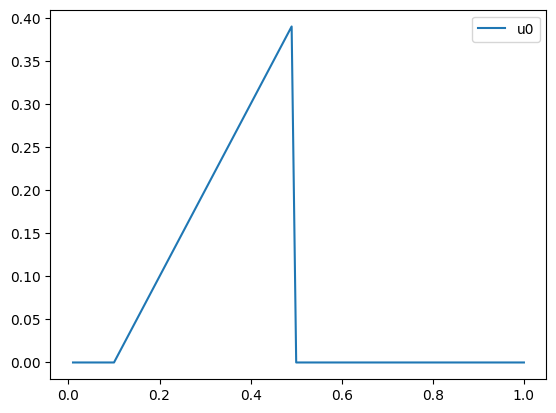

PyObject <matplotlib.legend.Legend object at 0x7f14cc9879d0>

In [7]:
# first order equation
# ∂ₜu + a∂ₓu = 0
# u(0,x) = ((x > 0.1) && (x < 0.5)) ? x-0.1 : 0.0

Δx = 0.01
x = Δx:Δx:1.0 |> Vector
N = length(x)
ord_deriv = 1
ord_approx = 2
a = 100
dt = 0.0001 # CFL: |aΔt/Δx| ≤ 1
Nt = 30
u0 = map(x -> ((x > 0.1) && (x < 0.5)) ? x-0.1 : 0.0, x)
plot(x, u0, label = "u0")
legend()

In [8]:
# efficient way to build fast lazy finite differences operators
# check more in http://diffeqoperators.sciml.ai/stable/operators/derivative_operators/
D = CenteredDifference(ord_deriv, ord_approx, Δx, N)
bc = PeriodicBC(Float64)
D = sparse(D*bc)[1]
Matrix(D)

100×100 Matrix{Float64}:
   0.0   50.0    0.0    0.0    0.0  …    0.0    0.0    0.0    0.0  -50.0
 -50.0    0.0   50.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0  -50.0    0.0   50.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0  -50.0    0.0   50.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0  -50.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0  -50.0  …    0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0  …    0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
   ⋮                      

In [9]:
# solve PDE with explicit method and CenteredDifference
U = zeros(N,Nt)
U[:,1] = copy(u0)
for i in 2:Nt
    U[:,i] = U[:,i-1] - (dt * a) .* (D * U[:,i-1])
end

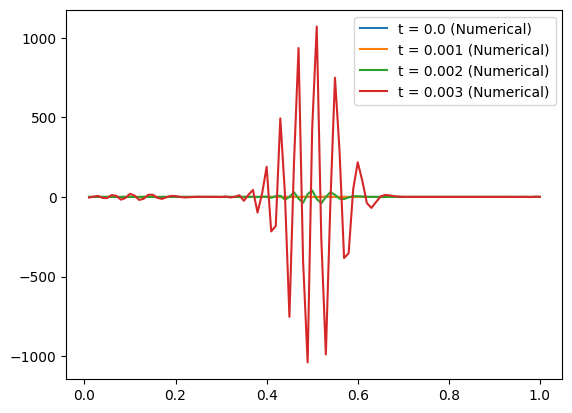

PyObject <matplotlib.legend.Legend object at 0x7f14cc887990>

In [10]:
plot(x, U[:,1], label = "t = 0.0 (Numerical)")
plot(x, U[:,10], label = "t = $(dt * 10) (Numerical)")
plot(x, U[:,20], label = "t = $(dt * 20) (Numerical)")
plot(x, U[:,Nt], label = "t = $(dt * Nt) (Numerical)")
legend()
# unstable

In [11]:
# Lets try upwind scheme
# Du = (u_{j} - u_{j-1})/Δx when a > 0
# Du = (u_{j+1} - u_{j})/Δx when a < 0

# in UpwindDifference, they write equation like du/dt = b*f(du,u,x,t), 
# b is the last argument of function, so in this case,
# if we write equation like ∂ₜu + Du = 0, b should be -1
D = UpwindDifference(ord_deriv, 1, Δx, N, -1)
D = -1 .* sparse(D*bc)[1]
Matrix(D) # u_{j} - u_{j-1}

100×100 Matrix{Float64}:
  100.0     0.0     0.0     0.0     0.0  …     0.0     0.0     0.0  -100.0
 -100.0   100.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0  -100.0   100.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0  -100.0   100.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0  -100.0   100.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0  -100.0  …     0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0  …     0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0


In [12]:
U = zeros(N,Nt)
U[:,1] = copy(u0)
for i in 2:Nt
    U[:,i] = U[:,i-1] - (dt * a) .* (D * U[:,i-1])
end

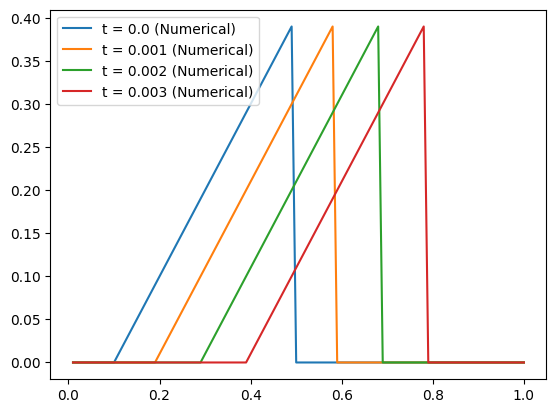

PyObject <matplotlib.legend.Legend object at 0x7f14cc9bbb10>

In [13]:
plot(x, U[:,1], label = "t = 0.0 (Numerical)")
plot(x, U[:,10], label = "t = $(dt * 10) (Numerical)")
plot(x, U[:,20], label = "t = $(dt * 20) (Numerical)")
plot(x, U[:,Nt], label = "t = $(dt * Nt) (Numerical)")
legend()
# just like a wave moves from left to right with speed a

In [ ]:
# what if we use a bigger Δx
Δx = 0.02
x = Δx:Δx:1.0 |> Vector
N = length(x)
ord_deriv = 1
ord_approx = 2
a = 100
dt = 0.0001 # CFL: |aΔt/Δx| ≤ 1
Nt = 30
u0 = map(x -> ((x > 0.1) && (x < 0.5)) ? x-0.1 : 0.0, x)

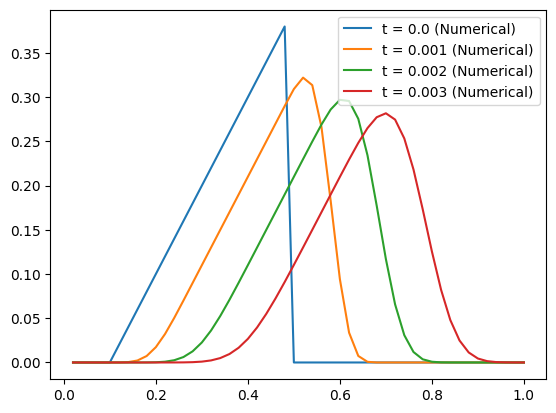

PyObject <matplotlib.legend.Legend object at 0x7f14cc790510>

In [15]:
D = UpwindDifference(ord_deriv, 1, Δx, N, -1)
D = -1 .* sparse(D*bc)[1]

U = zeros(N,Nt)
U[:,1] = copy(u0)
for i in 2:Nt
    U[:,i] = U[:,i-1] - (dt * a) .* (D * U[:,i-1])
end

plot(x, U[:,1], label = "t = 0.0 (Numerical)")
plot(x, U[:,10], label = "t = $(dt * 10) (Numerical)")
plot(x, U[:,20], label = "t = $(dt * 20) (Numerical)")
plot(x, U[:,Nt], label = "t = $(dt * Nt) (Numerical)")
legend()

# it still moves from left to right but it also acts like diffusion equation, why?

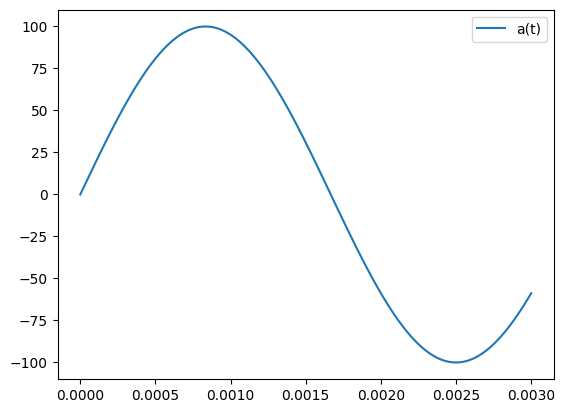

PyObject <matplotlib.legend.Legend object at 0x7f14cc15dc50>

In [31]:
# let's check the case when a(x,t) is not a constant
# e.g. a(x,t) = a(t) = 100sin(600πt)
# so the solution should moves from left to right, then moves back
Δx = 0.001  # using a smaller Δx to get more accurate solution 
x = Δx:Δx:1.0 |> Vector
N = length(x)
ord_deriv = 1
ord_approx = 2
dt = 0.00001 
Nt = 300
t = 0:dt:Nt*dt
a = 100 .* sinpi.(600 .* t)
plot(t,a,label="a(t)")
legend()

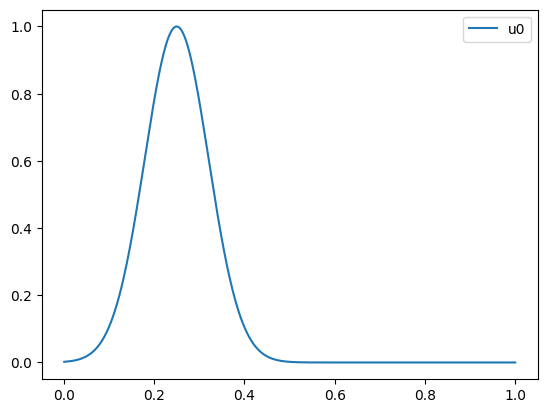

PyObject <matplotlib.legend.Legend object at 0x7f14cc16b290>

In [32]:
u0 = map(x -> exp(-100*(x-0.25)^2), x)
plot(x,u0,label="u0")
legend()

In [33]:
DL = UpwindDifference(ord_deriv, 1, Δx, N, -1)
bc = PeriodicBC(Float64)
DL = -1 .* sparse(DL*bc)[1]

DR = UpwindDifference(ord_deriv, 1, Δx, N, 1)
DR = sparse(DR*bc)[1]

a⁺ = max.(a,0.0)
a⁻ = min.(a,0.0)

U = zeros(N,Nt)
U[:,1] = copy(u0)

# Note: aDU = a⁺ * DL * U + a⁻ * DR * U
for i in 2:Nt
    U[:,i] = U[:,i-1] - dt .* (a⁺[i] .* (DL * U[:,i-1]) + a⁻[i] .* (DR * U[:,i-1]))
end

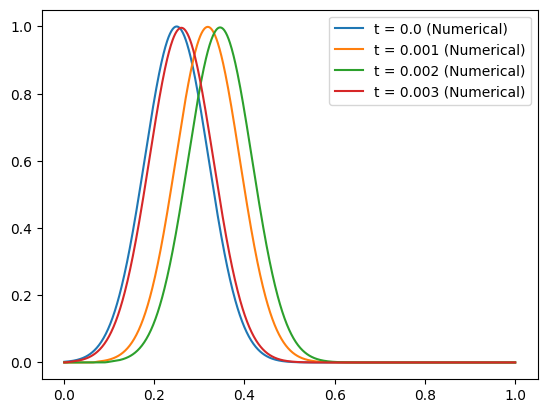

PyObject <matplotlib.legend.Legend object at 0x7f14cbfe5610>

In [35]:
plot(x, U[:,1], label = "t = 0.0 (Numerical)")
plot(x, U[:,100], label = "t = $(dt * 100) (Numerical)")
plot(x, U[:,200], label = "t = $(dt * 200) (Numerical)")
plot(x, U[:,Nt], label = "t = $(dt * Nt) (Numerical)")
legend()
